# Project 5 - SQL Queries

### Project Definition
---
In this project I will be using BigQuery to pull a dataset to perform SQL queries on.  I will then use SQL to explory the dataset.  I will use various plotting techniques to visualize some of the data. 

##Imports

In [54]:
from google.cloud import bigquery
from google.colab import auth
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
projectid='project-5-sql'

In [56]:
auth.authenticate_user()
print('Authenticated')

Authenticated


##Performing Queries
---
Located 3 different datasets that interest me.  For this project, I will be working with the usa_names dataset.  

In [57]:
client = bigquery.Client(project=projectid)

In [58]:
# bigquery-public-data.usa_names.usa_1910_current
# bigquery-public-data:sdoh_hrsa_shortage_areas.hpsa_primary_care
# bigquery-public-data:sdoh_cdc_wonder_natality.county_natality

In [59]:
# Checking the size of the chosen data set
query = '''
    SELECT 
    COUNT(*) as total
    FROM `bigquery-public-data.usa_names.usa_1910_current` '''

row_count = client.query(query).to_dataframe().total[0]

print(f'Full dataset has {row_count} rows')

Full dataset has 6215834 rows


In [60]:
# Seeing what tables fall under the usa_names dataset in BigQuery.
df_ref = client.dataset('usa_names', project = 'bigquery-public-data')
dataset = client.get_dataset(df_ref)
# Get all the tables in the dataset
tables = list(client.list_tables(dataset))

# Print names of all tables in the dataset
for table in tables: 
  print(table.table_id)

usa_1910_2013
usa_1910_current


###What does our dataset look like? 

In [61]:
# Indicating the table I would like to use.
table_ref = dataset.table('usa_1910_current')
# API request - fetch the table
table = client.get_table(table_ref)

# See the table's schema - name, field type, mode, description
table.schema

[SchemaField('state', 'STRING', 'NULLABLE', '2-digit state code', ()),
 SchemaField('gender', 'STRING', 'NULLABLE', 'Sex (M=male or F=female)', ()),
 SchemaField('year', 'INTEGER', 'NULLABLE', '4-digit year of birth', ()),
 SchemaField('name', 'STRING', 'NULLABLE', 'Given name of a person at birth', ()),
 SchemaField('number', 'INTEGER', 'NULLABLE', 'Number of occurrences of the name', ())]

In [62]:
# Preview the first twenty lines of the table
client.list_rows(table, max_results=20).to_dataframe()

,state,gender,year,name,number
0,AK,F,1910,Mary,14
1,AK,F,1910,Annie,12
2,AK,F,1910,Anna,10
3,AK,F,1910,Margaret,8
4,AK,F,1910,Helen,7
5,AK,F,1910,Elsie,6
6,AK,F,1910,Lucy,6
7,AK,F,1910,Dorothy,5
8,AK,F,1911,Mary,12
9,AK,F,1911,Margaret,7


In [63]:
# Setting up constants to limit how much data is queried.
ONE_MB = 1000*1000
ONE_GB = 1000*ONE_MB

In [64]:
# Performing a dry run to see how many bytes are in the dataset
query = """
        SELECT *
        FROM bigquery-public-data.usa_names.usa_1910_current
        LIMIT 5
        """


dry_run_config = bigquery.QueryJobConfig(dry_run = True)
dry_run_query_job = client.query(query, job_config= dry_run_config)
dry_run_query_job.total_bytes_processed

191924616

In [65]:
# Pulling the first 10 rows of the table 
query = """
        SELECT *
        FROM bigquery-public-data.usa_names.usa_1910_current
        LIMIT 10
        """
df_all = client.query(query).to_dataframe()
df_all.head(10)

,state,gender,year,name,number
0,AK,F,1910,Mary,14
1,AK,F,1910,Annie,12
2,AK,F,1910,Anna,10
3,AK,F,1910,Margaret,8
4,AK,F,1910,Helen,7
5,AK,F,1910,Elsie,6
6,AK,F,1910,Lucy,6
7,AK,F,1910,Dorothy,5
8,AK,F,1911,Mary,12
9,AK,F,1911,Margaret,7


###What is the total number of records in the dataset?
---
There are a total of 6,215,834 records. 

In [66]:
# Getting a count of the total number of records
query = """
        SELECT COUNT (*)
        FROM bigquery-public-data.usa_names.usa_1910_current
        """
df = client.query(query).to_dataframe()
df.head()

,f0_
0,6215834


In [67]:
# Pulling data more toward the middle of the table

query = """
        SELECT *
        FROM bigquery-public-data.usa_names.usa_1910_current
        LIMIT 10 OFFSET 3000000
        """
df = client.query(query).to_dataframe()
df.head(10)

,state,gender,year,name,number
0,TX,F,1982,Seema,6
1,TX,F,1982,Shane,6
2,TX,F,1982,Shanell,6
3,TX,F,1982,Sharhonda,6
4,TX,F,1982,Sharika,6
5,TX,F,1982,Sharona,6
6,TX,F,1982,Shera,6
7,TX,F,1982,Shilpa,6
8,TX,F,1982,Shonna,6
9,TX,F,1982,Shonte,6


###How many unique names are in the dataset?
---
32110 of the 6M+ records are unique names

In [68]:
# Checking the number of unique names
query = """
        SELECT DISTINCT name 
        FROM bigquery-public-data.usa_names.usa_1910_current
        """
df_uniq = client.query(query).to_dataframe()
uniq_names = df_uniq['name']
print(f"There are {uniq_names.count()} unique names")

There are 32110 unique names


In [69]:
df_uniq

,name
0,Mary
1,Annie
2,Anna
3,Margaret
4,Helen
...,...
32105,Donzel
32106,Edgel
32107,Delmos
32108,Delmus


###How many of the names are male and how many are female?
---
- There are 2,756,246 Males
- There are 3,459,588 Females
- Using a pie chart through Matplotlib to visualize the percentages of male vs. female. 

In [70]:
# Number of names with M as the gender
query = """
        SELECT COUNT (name)
        FROM bigquery-public-data.usa_names.usa_1910_current
        WHERE gender = "M"
        """
df_male = client.query(query).to_dataframe()
df_male.head()

,f0_
0,2756246


In [71]:
# Number of names with F as the gender
query = """
        SELECT COUNT (name)
        FROM bigquery-public-data.usa_names.usa_1910_current
        WHERE gender = "F"
        """
df_female = client.query(query).to_dataframe()
df_female.head()

,f0_
0,3459588


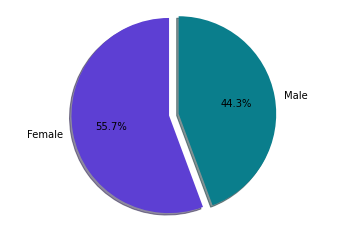

In [72]:
# Plotting the percent of male vs. female names. 
labels = 'Female', 'Male'
df = [3459588, 2756246]
explode = (0, 0.1)
colors = ['#5D3FD3', '#0a7e8c']

fig1, ax1 = plt.subplots()
ax1.pie(df, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

###How many unique names are in a specified year.  
---
There were 4897 unique names in 1974. 

In [73]:
# Checking how may unique names show for a given year. 
query = """
        SELECT DISTINCT name
        FROM bigquery-public-data.usa_names.usa_1910_current
        WHERE year = 1974
        """
df = client.query(query).to_dataframe()
uniq_names_fryr = df['name']
print(f"There are {uniq_names_fryr.count()} unique names")

There are 4897 unique names


###How many names possess the same root name?
---
- 571 Total names have the root of 'Mar' (M and F).
- 459 Female names have the root of 'Mar'

In [74]:
# Choosing a root name to see how many names are derived from it.
# Code can be modified to show all names with a given root name for both M and F by removing the AND statement. 
query = """
        SELECT DISTINCT name
        FROM bigquery-public-data.usa_names.usa_1910_current
        WHERE name LIKE "Mar%" AND gender != "M"
        """
df = client.query(query).to_dataframe()
same_rt_nm = df['name']
print(f"There are {same_rt_nm.count()} names with the specified root name")

There are 459 names with the specified root name


In [75]:
# Printing the dataframe of names with the same root name
same_rt_nm

0             Mary
1         Margaret
2            Marie
3           Martha
4         Marjorie
          ...     
454        Maryela
455         Maryse
456    Mariaemilia
457         Maraki
458        Maryiah
Name: name, Length: 459, dtype: object

###What was the first year a specified name appears?
---
I found it fun to try to find names which first show up in later years. 




In [76]:
# Creating a print statement to randomly select a name from our unique name list that we can enter in the next block. 
print(df_uniq['name'].sample().values)

['Kabir']


In [77]:
# Checking the first year a specified name shows up in the records. 
query = """
        SELECT MIN(year) AS first_year, name
        FROM bigquery-public-data.usa_names.usa_1910_current
        WHERE name LIKE "Marshelia"
        GROUP BY name
        """
df = client.query(query).to_dataframe()
df.head()

,first_year,name
0,1957,Marshelia


###How many of a specified name in a specified state for each year?





In [78]:
# Listing a specified name and state to see top ten years for that name in that state. 
query = """
        SELECT *
        FROM bigquery-public-data.usa_names.usa_1910_current
        WHERE name = "Jesus" AND state = "NM"
        ORDER BY number DESC
        """
df_name_st = client.query(query).to_dataframe()
df_name_st.head(10)

,state,gender,year,name,number
0,NM,M,1999,Jesus,109
1,NM,M,2008,Jesus,100
2,NM,M,2002,Jesus,95
3,NM,M,2006,Jesus,95
4,NM,M,2007,Jesus,95
5,NM,M,2001,Jesus,94
6,NM,M,2005,Jesus,90
7,NM,M,2004,Jesus,88
8,NM,M,2000,Jesus,86
9,NM,M,1993,Jesus,84


###Which years was a specified name used most/least?  
---
  With this question, I created two groups of code (one for least and one for most) and I noticed that, in some cases, a year showed up on both the least list and the most list.  I then created the third block of code which pulled the sum of all instances in all states.  

In [79]:
#Checking which year had the most of a specified name
query = """
        SELECT number, name, year, state
        FROM bigquery-public-data.usa_names.usa_1910_current
        WHERE name = "Anna" 
        ORDER BY number DESC
        """
df_most = client.query(query).to_dataframe()
df_most.head()

,number,name,year,state
0,3623,Anna,1915,PA
1,3594,Anna,1918,PA
2,3582,Anna,1916,PA
3,3533,Anna,1917,PA
4,3187,Anna,1920,PA


In [80]:
# Checking which year had the least of a specified name
query = """
        SELECT number, name, year, state
        FROM bigquery-public-data.usa_names.usa_1910_current
        WHERE name = "Anna"
        ORDER BY number
        """
df = client.query(query).to_dataframe()
df.head()

,number,name,year,state
0,5,Anna,1917,AK
1,5,Anna,1919,AK
2,5,Anna,1931,AK
3,5,Anna,1933,AK
4,5,Anna,1944,AK


In [81]:
# Combining all instances of a specified name from all states. 
query = """
        SELECT SUM(number) AS sum_number, name, year
        FROM bigquery-public-data.usa_names.usa_1910_current
        WHERE name = "Anna"
        GROUP BY name, year
        ORDER BY sum_number DESC
        """
df = client.query(query).to_dataframe()
df.head()

,sum_number,name,year
0,15673,Anna,1918
1,15224,Anna,1916
2,15160,Anna,1917
3,15124,Anna,1915
4,14589,Anna,1920


###What names show up as being both male and female names?
---
  When answering this question, I put in a few names which are thought of (socially) as being one gender, and found they fell in both gender categories.  With assistance from my classmate, I was able to make a list of names that showed up as one gender or the other.  Then for fun decided to see find people who have a name that might be considered a name for the opposite gender (top ten).

In [82]:
# Finding names which show as both male and female.
query = """
        SELECT DISTINCT name, gender
        FROM bigquery-public-data.usa_names.usa_1910_current
        WHERE name = "Amy" 
        """
df = client.query(query).to_dataframe()
df.tail(10)

,name,gender
0,Amy,F
1,Amy,M


In [83]:
# Getting a list of names which show as one gender, but not the other.  By removing the 'Where m.name is null', it will show
# names that show on both gender lists.
query = """
  SELECT m.name AS Male_Name, f.name AS Female_Name from 
    (SELECT DISTINCT name
    from bigquery-public-data.usa_names.usa_1910_current
    where gender = "M") as m
  right join 
    (SELECT DISTINCT name
    from bigquery-public-data.usa_names.usa_1910_current
    where gender = "F") as f on m.name = f.name

  WHERE m.name IS NULL
    """
df_f_only = client.query(query).to_dataframe()
df_f_only.head(10)

,Male_Name,Female_Name
0,None,Agnes
1,None,Clara
2,None,Gertrude
3,None,Stella
4,None,Vera
5,None,Nellie
6,None,Lena
7,None,Mabel
8,None,Dolly
9,None,Cecelia


In [84]:
# Adapting last block of code to create a dataframe for names which show as M but not F.
query = """
  SELECT m.name AS Male_Name, f.name AS Female_Name from 
    (SELECT DISTINCT name
    from bigquery-public-data.usa_names.usa_1910_current
    where gender = "M") as m
  left join 
    (SELECT DISTINCT name
    from bigquery-public-data.usa_names.usa_1910_current
    where gender = "F") as f on m.name = f.name

  WHERE f.name IS NULL
    """
df_m_only = client.query(query).to_dataframe()
df_m_only.head(10)

,Male_Name,Female_Name
0,Nick,None
1,Simon,None
2,Simeon,None
3,Fredrick,None
4,Moses,None
5,Bob,None
6,Allan,None
7,Guy,None
8,Wassillie,None
9,Rick,None


In [85]:
# Adapting the query above to find names that appear under both the male and female category. 
query = """
  SELECT m.name AS Male_Name, f.name AS Female_Name from 
    (SELECT DISTINCT name
    from bigquery-public-data.usa_names.usa_1910_current
    where gender = "M") as m
  right join 
    (SELECT DISTINCT name
    from bigquery-public-data.usa_names.usa_1910_current
    where gender = "F") as f on m.name = f.name

    """
df = client.query(query).to_dataframe()
df.head(10)

,Male_Name,Female_Name
0,Mary,Mary
1,Annie,Annie
2,Anna,Anna
3,Margaret,Margaret
4,Helen,Helen
5,Elsie,Elsie
6,Lucy,Lucy
7,Dorothy,Dorothy
8,Ruth,Ruth
9,Elizabeth,Elizabeth


In [86]:
 # Getting a list of names which are listed as M or F that I can use in my other queries by changing the gender in the query.
 query = """
    SELECT DISTINCT name
    FROM bigquery-public-data.usa_names.usa_1910_current
    WHERE gender = "M"
    """
df = client.query(query).to_dataframe()
df.head(10)

,name
0,John
1,James
2,Paul
3,Robert
4,Carl
5,Edward
6,George
7,William
8,Peter
9,Charles


In [87]:
# For fun, seeing which names I can find that are socially considered one gender, but show up under the 'opposite' gender. 
query = """
        SELECT *
        FROM bigquery-public-data.usa_names.usa_1910_current
        WHERE name = "Amy" and gender = "M"
        ORDER BY number DESC
        """
df_opp = client.query(query).to_dataframe()
df_opp.head(10)

,state,gender,year,name,number
0,DC,M,1989,Amy,13
1,CA,M,1984,Amy,12
2,NY,M,1973,Amy,11
3,CA,M,1971,Amy,10
4,TX,M,1985,Amy,10
5,TX,M,1986,Amy,10
6,MI,M,1976,Amy,9
7,OH,M,1970,Amy,9
8,PA,M,1980,Amy,9
9,CA,M,1973,Amy,8


In [88]:
# Checking the total number of rows we have for the query above.
df_opp.value_counts()

state  gender  year  name  number
VA     M       1972  Amy   5         1
IN     M       1972  Amy   6         1
IL     M       1971  Amy   6         1
               1972  Amy   5         1
               1976  Amy   5         1
                                    ..
NY     M       1977  Amy   6         1
               1974  Amy   6         1
               1973  Amy   11        1
               1969  Amy   5         1
CA     M       1971  Amy   10        1
Length: 68, dtype: int64

###What is the most popular name in each state?
---
  With assistance from a classmate, I was able to search for the most popular name for each state for a given year and also according to gender.  I plotted the combined most popular names for each state for a specific year using a categorical scatter plot from Seaborn. 

In [89]:
# Checking the sum of most popular name for a specified year.
query = """
WITH sums as (SELECT sum(number) as the_count, name, state
                FROM bigquery-public-data.usa_names.usa_1910_current
                WHERE year = 1957
                GROUP BY name, state)
SELECT a.* 
FROM sums a
INNER JOIN (SELECT MAX(the_count) as max_count, state
            FROM sums
            GROUP BY state) b on a.state = b.state and a.the_count = b.max_count
ORDER BY state
        """
df_mostpop = client.query(query).to_dataframe()
df_mostpop

,the_count,name,state
0,169,John,AK
1,2106,James,AL
2,970,James,AR
3,653,David,AZ
4,8269,Michael,CA
5,918,Michael,CO
6,1405,Michael,CT
7,830,Michael,DC
8,289,John,DE
9,2219,James,FL


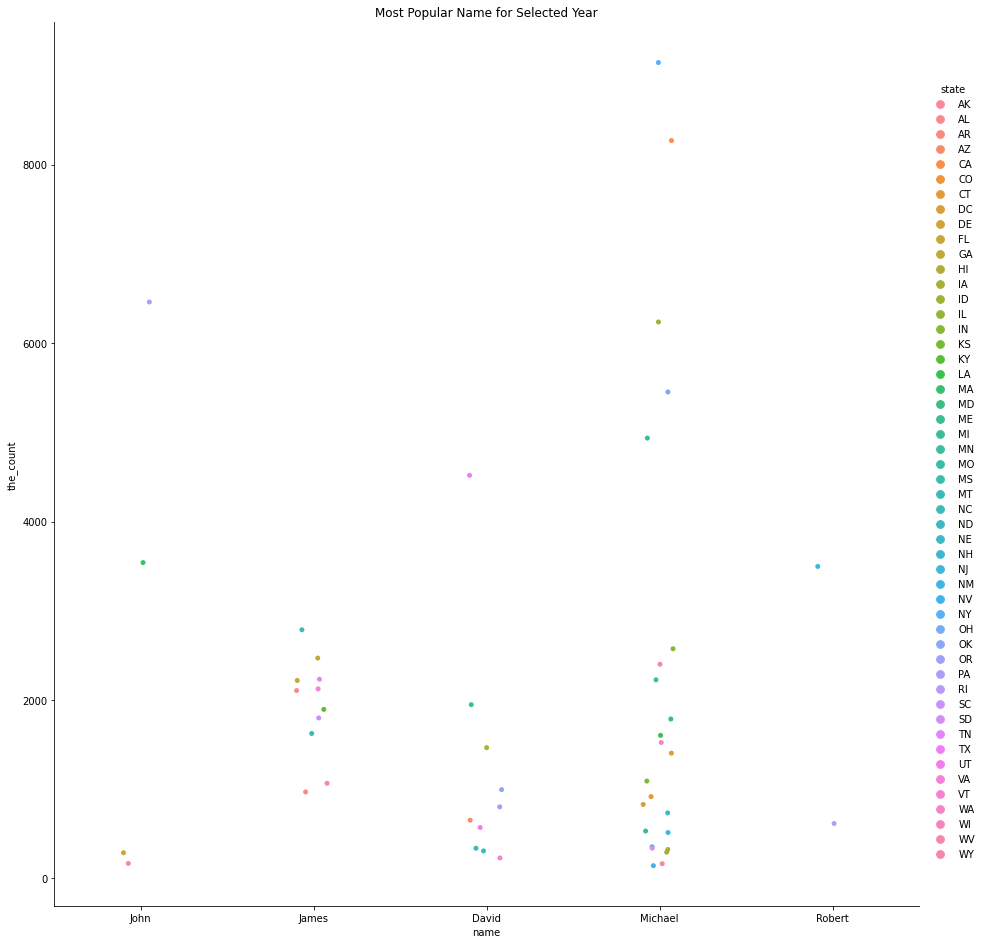

In [90]:
# Plotting the most popular names in each state for a specific year. 
sns.catplot(x='name', y='the_count', hue='state', data=df_mostpop, height=13,)
plt.title('Most Popular Name for Selected Year');

In [91]:
# Most popular name in each state with M as the gender. 
query = """
WITH sums as (SELECT MAX(number) as the_count, name, state
                FROM bigquery-public-data.usa_names.usa_1910_current
                WHERE gender = "M"
                GROUP BY name, state)
SELECT a.* 
FROM sums a
INNER JOIN (SELECT MAX(the_count) as max_count, state
            FROM sums
            GROUP BY state) b on a.state = b.state and a.the_count = b.max_count
ORDER BY state
        """
df = client.query(query).to_dataframe()
df

,the_count,name,state
0,207,Michael,AK
1,3038,James,AL
2,1622,James,AR
3,1045,Michael,AZ
4,8259,Michael,CA
5,973,Michael,CO
6,1624,Robert,CT
7,883,John,DC
8,311,Michael,DE
9,3493,Michael,FL


In [92]:
# Most popular name in each state with F as the gender. 
query = """
WITH sums as (SELECT MAX(number) as the_count, name, state
                FROM bigquery-public-data.usa_names.usa_1910_current
                WHERE gender = "F"
                GROUP BY name, state)
SELECT a.* 
FROM sums a
INNER JOIN (SELECT MAX(the_count) as max_count, state
            FROM sums
            GROUP BY state) b on a.state = b.state and a.the_count = b.max_count
ORDER BY state
        """
df = client.query(query).to_dataframe()
df

,the_count,name,state
0,164,Jessica,AK
1,2694,Mary,AL
2,1424,Linda,AR
3,876,Jessica,AZ
4,6951,Jessica,CA
5,1037,Linda,CO
6,1155,Linda,CT
7,615,Linda,DC
8,207,Jennifer,DE
9,2740,Jessica,FL


###What is the most popular names for a given time period?
---
  Adapted from above; just wanted to play with the most popular questions a bit more.  Here a period of time is given to determine the most popular names in that time period and then plotted with a 3D scatter plot using Plotly Express. 

In [93]:
# Checking the total of most popular name in each state for a given time period.
query = """
WITH sums as (SELECT sum(number) as range_total, name, state
                FROM bigquery-public-data.usa_names.usa_1910_current
                WHERE year BETWEEN 1910 AND 1940
                GROUP BY name, state)
SELECT a.* 
FROM sums a
INNER JOIN (SELECT max(range_total) as max_count, state
            FROM sums
            GROUP BY state) b on a.state = b.state and a.range_total = b.max_count
ORDER BY state
        """
df_range = client.query(query).to_dataframe()
df_range.head(50)

,range_total,name,state
0,873,Mary,AK
1,63774,Mary,AL
2,35963,James,AR
3,7839,Mary,AZ
4,58298,Robert,CA
5,14564,Mary,CO
6,25128,John,CT
7,8521,Mary,DC
8,3881,William,DE
9,23428,James,FL


In [94]:
# Plotting the most popular names in each state for the period given above.
fig = px.scatter_3d(df_range, x="name", y="range_total", z="state", color="range_total", size="range_total", hover_name="name")
fig.show()

## Name your baby activity

In [95]:
baby_gender = input("Enter M or F or UNK:  ")

if baby_gender == 'M':
  print(f"Your baby's name is: {(df_m_only['Male_Name'].sample().values)} Congratulations!")
elif baby_gender == 'F':
  print(f"Your baby's name is: {(df_f_only['Female_Name'].sample().values)} Congratulations!")
else: 
  print(f"Your baby's name is: {(uniq_names.sample().values)} Congratulations!")

Enter M or F or UNK:  F
Your baby's name is: ['Tsurue'] Congratulations!


##Conclusion
---
I'm sure the queries for this dataset could go on for a while.  I had a difficult time trying to think of a prediction I could make with a model, but with additional time, I would try to come up with one. 